<a href="https://colab.research.google.com/github/ninadcpa/dsc530/blob/main/Week8_Exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 8 - Exercise 9.1 and 10.1

Author - Ninad Patkhedkar

In [1]:
from google.colab import drive
import sys
import os

# This code is to just use code checked out from github on google drive
drive.mount('/content/drive')
sys.path.append('/content/drive/MyDrive/Colab Notebooks/ThinkStats/ThinkStats2/code/')
os.chdir('/content/drive/MyDrive/Colab Notebooks/ThinkStats/ThinkStats2/code/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Exercise 9.1**
As sample size increases, the power of a hypothesis test increases, which means it is more likely to be positive if the effect is real. Conversely, as sample size decreases, the test is less likely to be positive even if the effect is real.
To investigate this behavior, run the tests in this chapter with different subsets of the NSFG data. You can use thinkstats2.SampleRows to select a random subset of the rows in a DataFrame.

What happens to the p-values of these tests as sample size decreases? What is the smallest sample size that yields a positive test?

In [2]:
from __future__ import print_function, division

import first
import hypothesis
import scatter
import thinkstats2

import numpy as np

class DiffMeansResample(hypothesis.DiffMeansPermute):
    """Tests a difference in means using resampling."""
    
    def RunModel(self):
        """Run the model of the null hypothesis.
        returns: simulated data
        """
        group1 = np.random.choice(self.pool, self.n, replace=True)
        group2 = np.random.choice(self.pool, self.m, replace=True)
        return group1, group2
  

def RunResampleTest(firsts, others):
    """Tests differences in means by resampling.
    firsts: DataFrame
    others: DataFrame
    """
    data = firsts.prglngth.values, others.prglngth.values
    ht = DiffMeansResample(data)
    p_value = ht.PValue(iters=10000)
    print('\nmeans permute preglength')
    print('p-value =', p_value)
    print('actual =', ht.actual)
    print('ts max =', ht.MaxTestStat())

    data = (firsts.totalwgt_lb.dropna().values,
            others.totalwgt_lb.dropna().values)
    ht = hypothesis.DiffMeansPermute(data)
    p_value = ht.PValue(iters=10000)
    print('\nmeans permute birthweight')
    print('p-value =', p_value)
    print('actual =', ht.actual)
    print('ts max =', ht.MaxTestStat())


def RunTests(live, iters=1000):
    """Runs the tests from Chapter 9 with a subset of the data.
    live: DataFrame
    iters: how many iterations to run
    """
    n = len(live)
    firsts = live[live.birthord == 1]
    others = live[live.birthord != 1]

    # compare pregnancy lengths
    data = firsts.prglngth.values, others.prglngth.values
    ht = hypothesis.DiffMeansPermute(data)
    p1 = ht.PValue(iters=iters)

    data = (firsts.totalwgt_lb.dropna().values,
            others.totalwgt_lb.dropna().values)
    ht = hypothesis.DiffMeansPermute(data)
    p2 = ht.PValue(iters=iters)

    # test correlation
    live2 = live.dropna(subset=['agepreg', 'totalwgt_lb'])
    data = live2.agepreg.values, live2.totalwgt_lb.values
    ht = hypothesis.CorrelationPermute(data)
    p3 = ht.PValue(iters=iters)

    # compare pregnancy lengths (chi-squared)
    data = firsts.prglngth.values, others.prglngth.values
    ht = hypothesis.PregLengthTest(data)
    p4 = ht.PValue(iters=iters)

    print('%d\t%0.2f\t%0.2f\t%0.2f\t%0.2f' % (n, p1, p2, p3, p4))

In [3]:
thinkstats2.RandomSeed(18)

live, firsts, others = first.MakeFrames()
RunResampleTest(firsts, others)

n = len(live)
for _ in range(7):
    sample = thinkstats2.SampleRows(live, n)
    RunTests(sample)
    n //= 2


means permute preglength
p-value = 0.1674
actual = 0.07803726677754952
ts max = 0.2267524361042348

means permute birthweight
p-value = 0.0
actual = 0.12476118453549034
ts max = 0.11224350119686566
9148	0.16	0.00	0.00	0.00
4574	0.03	0.02	0.00	0.00
2287	0.04	0.07	0.00	0.00
1143	0.70	0.04	0.80	0.07
571	0.53	0.00	0.00	0.35
285	0.96	0.84	0.35	0.53
142	0.87	0.49	0.20	0.06



test1: difference in mean pregnancy length
test2: difference in mean birth weight
test3: correlation of mother's age and birth weight
test4: chi-square test of pregnancy length



Conclusion: As expected, tests that are positive with large sample
sizes become negative as we take away data.  

How much does the model affect the results?

Results:
means permute preglength

p-value = 0.1674
actual = 0.07803726677754952
ts max = 0.2267524361042348

means permute birthweight

p-value = 0.0
actual = 0.12476118453549034
ts max = 0.11224350119686566

Conclusions: Using resampling instead of permutation has very
little effect on the results.
The two models are based on slightly difference assumptions, and in
this example there is no compelling reason to choose one or the other.



**Execrcise 10.1**
Using the data from the BRFSS, compute the linear least squares fit for log(weight) versus height. How would you best present the estimated parameters for a model like this where one of the variables is log-transformed? If you were trying to guess someone’s weight, how much would it help to know their height?

Like the NSFG, the BRFSS oversamples some groups and provides a sampling weight for each respondent. In the BRFSS data, the variable name for these weights is finalwt. Use resampling, with and without weights, to estimate the mean height of respondents in the BRFSS, the standard error of the mean, and a 90% confidence interval. How much does correct weighting affect the estimates?

In [4]:
import brfss

df = brfss.ReadBrfss(nrows=None)
df = df.dropna(subset=['htm3', 'wtkg2'])
heights, weights = df.htm3, df.wtkg2
log_weights = np.log10(weights)

In [5]:
inter, slope = thinkstats2.LeastSquares(heights, log_weights)
inter, slope

(0.9930804163917808, 0.005281454169417994)

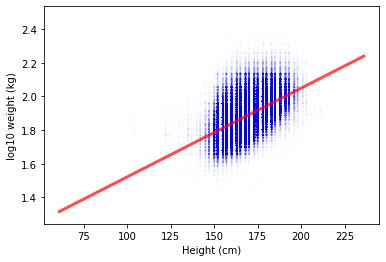

In [6]:
import thinkplot

thinkplot.Scatter(heights, log_weights, alpha=0.01, s=5)
fxs, fys = thinkstats2.FitLine(heights, inter, slope)
thinkplot.Plot(fxs, fys, color='red')
thinkplot.Config(xlabel='Height (cm)', ylabel='log10 weight (kg)', legend=False)

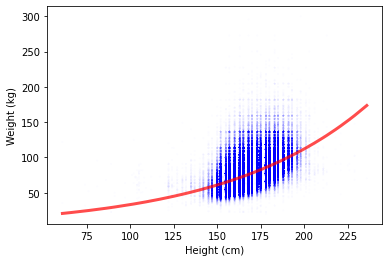

In [7]:
thinkplot.Scatter(heights, weights, alpha=0.01, s=5)
fxs, fys = thinkstats2.FitLine(heights, inter, slope)
thinkplot.Plot(fxs, 10**fys, color='red')
thinkplot.Config(xlabel='Height (cm)', ylabel='Weight (kg)', legend=False)

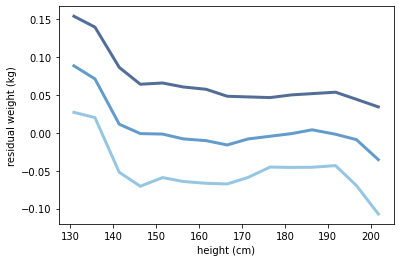

In [8]:
res = thinkstats2.Residuals(heights, log_weights, inter, slope)
df['residual'] = res

bins = np.arange(130, 210, 5)
indices = np.digitize(df.htm3, bins)
groups = df.groupby(indices)

means = [group.htm3.mean() for i, group in groups][1:-1]
cdfs = [thinkstats2.Cdf(group.residual) for i, group in groups][1:-1]

thinkplot.PrePlot(3)
for percent in [75, 50, 25]:
    ys = [cdf.Percentile(percent) for cdf in cdfs]
    label = '%dth' % percent
    thinkplot.Plot(means, ys, label=label)
    
thinkplot.Config(xlabel='height (cm)', ylabel='residual weight (kg)', legend=False)

In [9]:
rho = thinkstats2.Corr(heights, log_weights)
rho

0.531728260598358

In [10]:
r2 = thinkstats2.CoefDetermination(log_weights, res)
r2

0.282734943118932

In [11]:
rho**2 - r2

2.3314683517128287e-14

In [12]:
std_ys = thinkstats2.Std(log_weights)
std_ys

0.10320725030004864

In [13]:
std_res = thinkstats2.Std(res)
std_res

0.08740777080416112

How much height information reduces RMSE?

In [14]:
1 - std_res / std_ys

0.1530849765879294

Use resampling to compute sampling distributions for inter and slope.

In [15]:
t = []
for _ in range(100):
    sample = thinkstats2.ResampleRows(df)
    estimates = thinkstats2.LeastSquares(sample.htm3, np.log10(sample.wtkg2))
    t.append(estimates)

inters, slopes = zip(*t)

Plot the sampling distribution of slope.

{'xscale': 'linear', 'yscale': 'linear'}

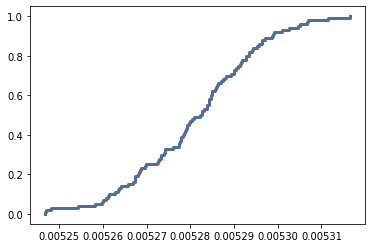

In [16]:
cdf = thinkstats2.Cdf(slopes)
thinkplot.Cdf(cdf)

Compute the p-value of the slope.

In [17]:
pvalue = cdf[0]
pvalue

0

Compute the 90% confidence interval of slope.

In [18]:
ci = cdf.Percentile(5), cdf.Percentile(95)
ci

(0.005258099751410852, 0.005304748531528845)

Compute the mean of the sampling distribution.

In [19]:
mean = thinkstats2.Mean(slopes)
mean

0.005281074413825519

Compute the standard deviation of the sampling distribution, which is the standard error.

In [20]:
stderr = thinkstats2.Std(slopes)
stderr

1.4197094551191132e-05

Resample rows without weights, compute mean height, and summarize results.

The following function takes a list of estimates and prints the mean, standard error, and 90% confidence interval.



In [23]:
%matplotlib inline

import random
from thinkstats2 import Mean, MeanVar, Var, Std, Cov

def Summarize(estimates, actual=None):
    mean = Mean(estimates)
    stderr = Std(estimates, mu=actual)
    cdf = thinkstats2.Cdf(estimates)
    ci = cdf.ConfidenceInterval(90)
    print('mean, SE, CI', mean, stderr, ci)

In [24]:
estimates_unweighted = [thinkstats2.ResampleRows(df).htm3.mean() for _ in range(100)]
Summarize(estimates_unweighted)

mean, SE, CI 168.95504752016004 0.0166636960203914 (168.9222599486651, 168.98246225671497)


Resample rows with weights. Note that the weight column in this dataset is called finalwt.

In [26]:
def ResampleRowsWeighted(df, column='finalwgt'):
    weights = df[column]
    cdf = thinkstats2.Cdf(dict(weights))
    indices = cdf.Sample(len(weights))
    sample = df.loc[indices]
    return sample

In [27]:
estimates_weighted = [ResampleRowsWeighted(df, 'finalwt').htm3.mean() for _ in range(100)]
Summarize(estimates_weighted)

mean, SE, CI 170.4959671779947 0.018211349507727324 (170.46811526101982, 170.52943167808564)
